In [36]:
import torch
import gymnasium
import safety_gymnasium
from src.init_env import SafeCartPoleWrapper, SafeMountainCarWrapper
from src.policy import PolicyNetwork
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def vis_env(model_link, env_id):
    step_nr = 300
    if env_id == "MountainCar-v0" or env_id == "MountainCarContinuous-v0":
        envs = gymnasium.vector.make(env_id, max_episode_steps = step_nr, num_envs = 1, render_mode = "human")
        envs = SafeMountainCarWrapper(envs)
    elif env_id == "CartPole-v1":
        envs = gymnasium.vector.make(env_id, max_episode_steps = step_nr, num_envs = 1, render_mode = "human")
        envs = SafeCartPoleWrapper(envs)       
    else:
        envs = safety_gymnasium.vector.make(env_id, max_episode_steps = step_nr, num_envs = 1, render_mode = "human")

    state_dim = envs.single_observation_space.shape[0]
    action_dim = envs.single_action_space.shape[0]   

    policy = PolicyNetwork(state_dim, action_dim, False, torch.device("cpu"))
    policy.load_state_dict(torch.load(model_link))

    episode_nr = 24

    states = np.zeros((episode_nr, step_nr + 1, state_dim), dtype=np.float32)
    actions = np.zeros((episode_nr, step_nr, action_dim), dtype=np.float32)
    costs = np.zeros((episode_nr, step_nr, 1), dtype=np.float32)
    next_states = np.zeros((episode_nr, step_nr, state_dim), dtype=np.float32)

    # Reset the environments for this batch
    s, _ = envs.reset()

    for i in range(episode_nr):
        for t in range(step_nr):
            # Sample action from policy
            a = policy.predict(s).cpu().numpy()

            # Record
            states[i, t] = s
            actions[i, t] = a

            # Step through environments
            s, _, cost, _, _, _ = envs.step(a)
            costs[i, t] = cost.reshape(-1, 1)
            next_states[i, t] = s

        # Final state
        states[i, step_nr] = s

    envs.close()

    return states, actions, costs, next_states  

In [37]:
states, actions, costs, next_states = vis_env("results/MountainCarContinuous/CEM/100-policy.pt", "MountainCarContinuous-v0")

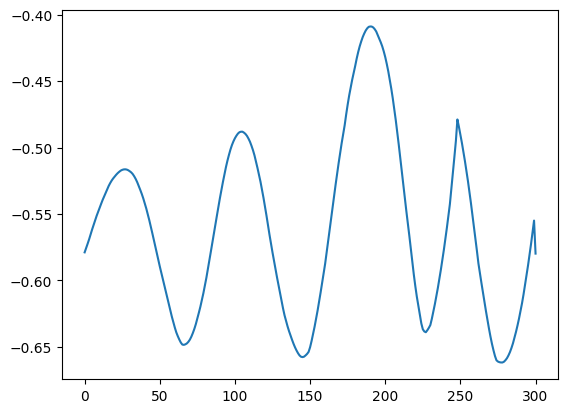

In [40]:
plt.plot(np.mean(states, axis=0)[:, 0])

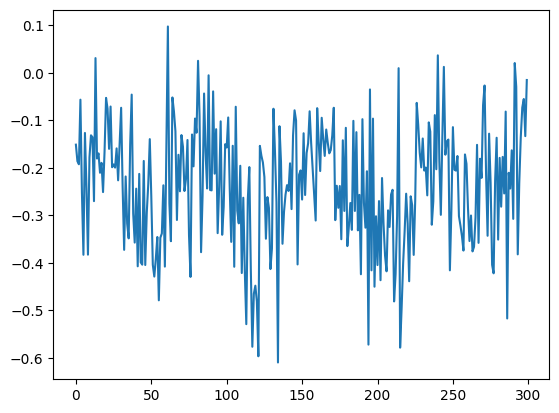

In [41]:
plt.plot(np.mean(actions, axis=0)[:, 0])

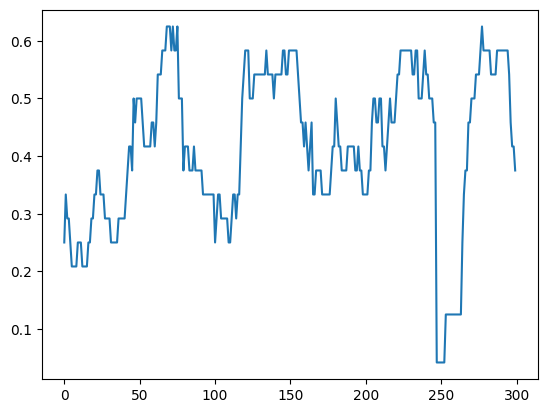

In [43]:
plt.plot(np.mean(costs, axis=0)[:, 0])

<Axes: xlabel='State', ylabel='Action'>

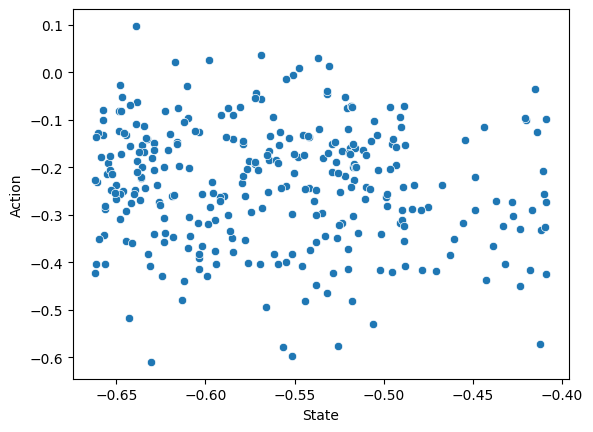

In [45]:
import pandas as pd
df = pd.DataFrame({"State": np.mean(states, axis=0)[: -1, 0], "Action": np.mean(actions, axis=0)[:, 0]})
sns.scatterplot(data = df, x = "State", y = "Action")